In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl
from sklearn import neighbors
import copy
from sklearn.cluster import DBSCAN
import emcee
import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, [1,500], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

# 4. Start here for using trigger times

In [2]:
with open('all_chan_all_trigger_times_overlapped_new_STALTA.pkl', 'rb') as file:
    # Serialize and write the data to the file
    list_of_times = pkl.load(file)

# 5. Plot a single set of triggers to check accuracy

In [3]:
## Print an example list of triggers ##
""" Triggers from one file """
files_list = sorted(glob('/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/*'))
file_number = 677

triggers_of_interest = list_of_times[file_number]
event_files = files_list[file_number+2: file_number+4]

In [4]:
### Get the data that the triggers had triggered on ###

for n, i in enumerate(event_files):
    if n == 0:

        filt_filled_data, times, attrs = preprocessing_step(i)
    else:
        first_data = copy.deepcopy(filt_filled_data)
        first_times = copy.deepcopy(times)

        filt_filled_data, times, attrs = preprocessing_step(i)

        all_data = np.concatenate((first_data, filt_filled_data), axis=0)
        all_times = np.concatenate((first_times, times), axis=0)
channels_arr = np.arange(0, attrs['NumberOfLoci'],1)

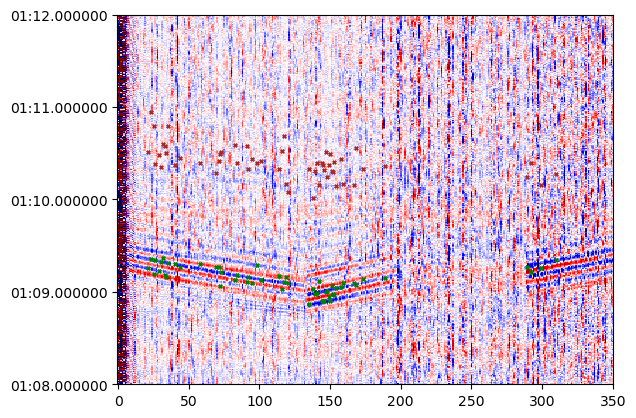

In [5]:
### Plot the data ###

fig, ax = plt.subplots()

ax.pcolormesh(channels_arr, all_times, all_data, vmin=-0.05, vmax=0.05, cmap='seismic')

for n,i in enumerate(triggers_of_interest):
    trigs_arr = np.array(i)
    if not trigs_arr.any():
        continue
    else:
        chan_plot = np.array([n]*trigs_arr.shape[0])
        trig_start_time =  np.array(i)[:,0]
        trig_off_time = np.array(i)[:,1]


        ax.scatter(chan_plot, trig_start_time, marker='x',color='green', s=6)
        ax.scatter(chan_plot, trig_off_time, marker='x',color='brown', s=6)

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 8, 0),datetime.datetime(2024, 12, 19, 4, 1, 12, 0)])
plt.show()

# 6. Cull some of the detections for duplicates and erroneous triggers

## 6.1 Remove duplicates

In [6]:
def remove_nearby_datetimes(datetime_list, threshold_seconds):
    """
    Removes datetime values from a list that are within a specified time threshold of each other.

    Args:
        datetime_list: A list of datetime objects.
        threshold_seconds: The threshold in seconds to consider datetimes as "near" each other.

    Returns:
        A new list with the nearby datetimes removed.
    """
    if not datetime_list:
        return []

    datetime_list.sort()  # Ensure datetimes are in chronological order
    result = [datetime_list[0]]
    last_added = datetime_list[0]

    for dt in datetime_list[1:]:
        if (dt - last_added).total_seconds() > threshold_seconds:
            result.append(dt)
            last_added = dt

    return result

## 6.2 Remove triggers that happen at the start of the window.

In [7]:
all_chans_all_detects_culled = {}
for chan_number in np.arange(0,351,1):
    chan_detects = []


    for n, i in enumerate(list_of_times):
        """ Below this is the code to check for the bad triggers on start"""

        if n ==0:
            continue

        if i[chan_number].any():


            first_detect = np.asarray(i[chan_number])[:,0][0]

            if isinstance(first_detect, int):
                continue
            time_start = datetime.datetime(year = first_detect.year, 
                                           month=first_detect.month, 
                                           day=first_detect.day, 
                                           hour=first_detect.hour, 
                                           minute=first_detect.minute
                                           )
            event_time_within_minute = first_detect - time_start

            second_of_detect = event_time_within_minute.seconds + event_time_within_minute.microseconds/1e6

            if 2.9 < second_of_detect < 4:

                """ Below this it remains the same"""
                for j in i[chan_number][1:]: #skip the first one

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
            else:
                for j in i[chan_number]:

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
    

    culled = remove_nearby_datetimes(chan_detects, 0.5)

    all_chans_all_detects_culled[str(chan_number)] = culled


# 7.1 Show all the detections

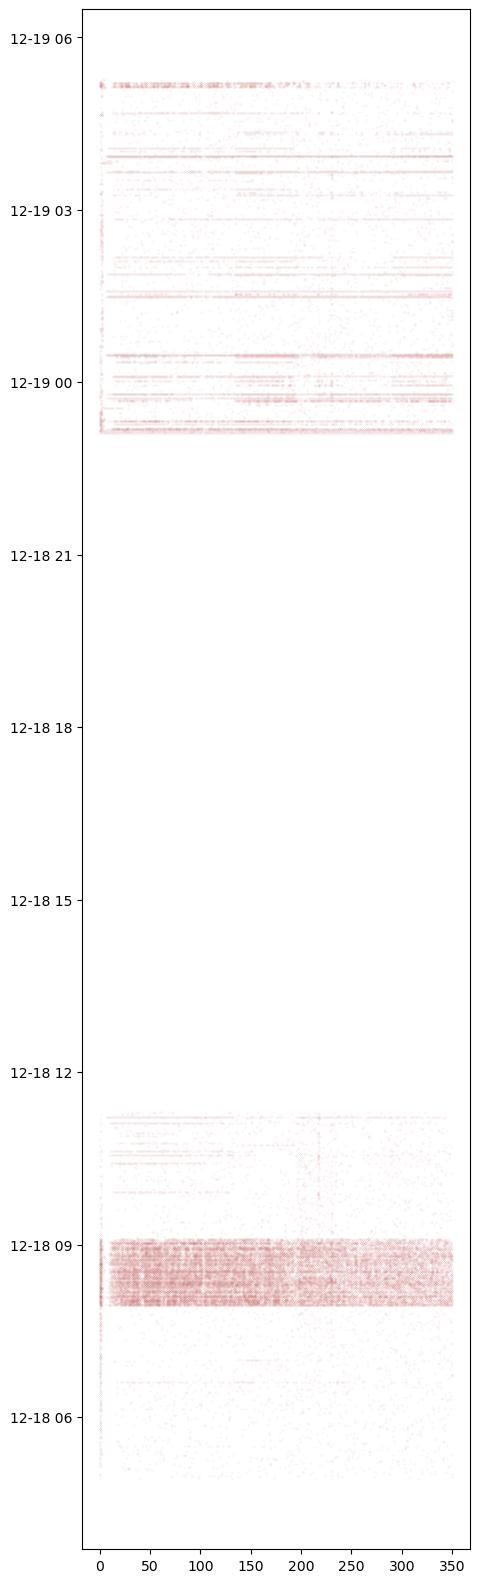

In [8]:
fig, ax = plt.subplots(figsize=(5,20))

for i in all_chans_all_detects_culled:
    start_times = all_chans_all_detects_culled[str(i)]
    chan = [int(i)] * len(all_chans_all_detects_culled[str(i)])
    ax.scatter(chan, start_times, s = .002, c = 'indianred' )

#ax.set_ylim([datetime.datetime(2024, 12, 18, 9, 0, 0, 0),datetime.datetime(2024, 12, 18, 9, 1, 0, 0)])

plt.show()

# 7.2 Show just a subset

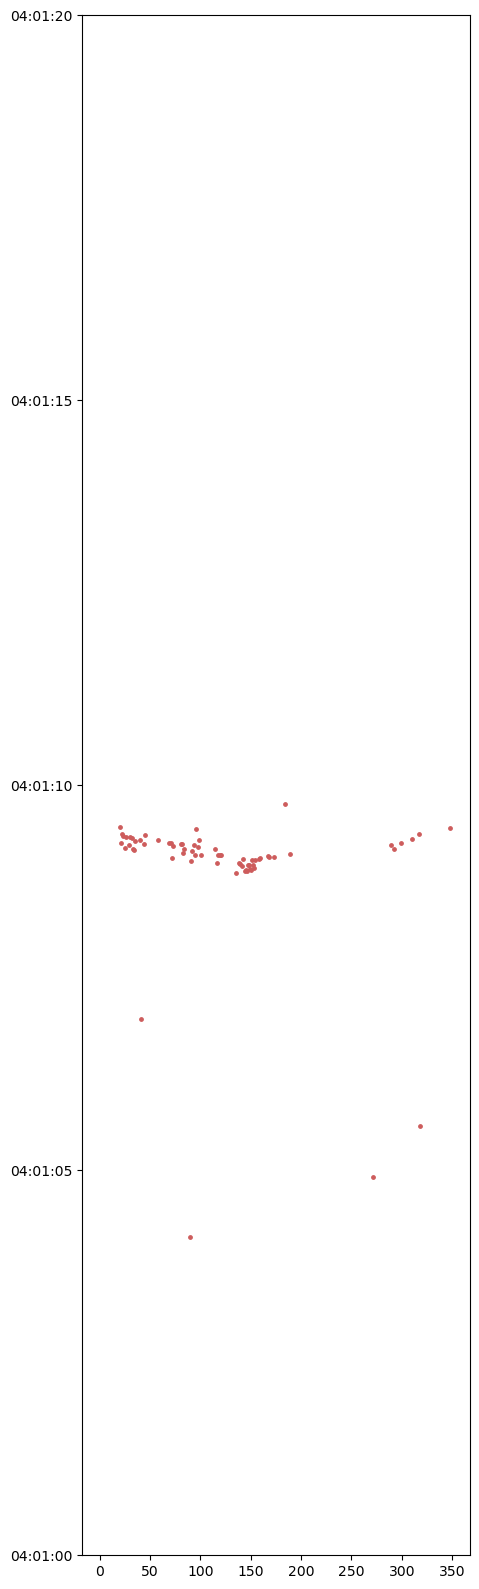

In [6]:
fig, ax = plt.subplots(figsize=(5,20))

for i in all_chans_all_detects_culled:
    start_times = all_chans_all_detects_culled[str(i)]
    chan = [int(i)] * len(all_chans_all_detects_culled[str(i)])
    ax.scatter(chan, start_times, s = 6, c = 'indianred' )

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

plt.show()

# 8. Filter events to only keep points near in space and time

In [8]:
def group_seismic_detections(detections, space_threshold, time_threshold_seconds):
    """
    Groups seismic wave detections based on spatial and temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats, representing space),
                           and values are lists of datetime objects (representing detections in time).
        space_threshold (float): Maximum distance between points to be considered in the same group.
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections.

    Returns:
        dict: Filtered and grouped detections with datetime values.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_datetimes = []  # Store original datetime values for reference

    for dist, times in detections.items():
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_datetimes.append(dt)  # Keep the original datetime

    if not data_points:
        return {}

    # Convert to NumPy array
    data_array = np.array(data_points)

    # Apply DBSCAN clustering (space in distance, time in seconds)
    clustering = DBSCAN(eps=max(space_threshold, time_threshold_seconds), min_samples=2, metric='euclidean').fit(data_array)

    # Extract labels
    labels = clustering.labels_

    # Remove noise points (-1 label)
    clustered_data = data_array[labels != -1]
    clustered_times = np.array(original_datetimes)[labels != -1]  # Keep corresponding original datetime values

    # Reorganize into a dictionary
    grouped_detections = {}
    for (dist, _), dt in zip(clustered_data, clustered_times):
        dist = round(float(dist), 5)  # Ensure floating point consistency
        if dist not in grouped_detections:
            grouped_detections[dist] = []
        grouped_detections[dist].append(dt)

    return grouped_detections




In [9]:
grouped_detections = group_seismic_detections(all_chans_all_detects_culled, 5, 1)

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


## 8.1 show filtered events

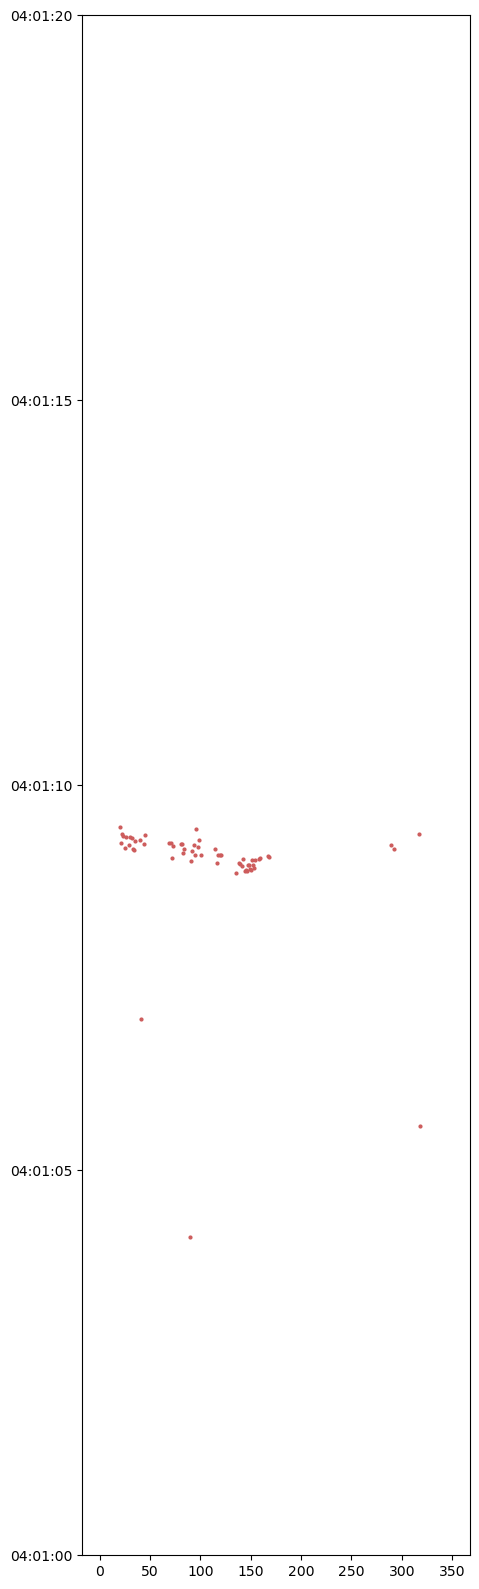

In [9]:
fig, ax = plt.subplots(figsize=(5,20))

for i in grouped_detections:
    start_times = grouped_detections[i]
    chan = [int(i)] * len(grouped_detections[i])
    ax.scatter(chan, start_times, s = 4, c = 'indianred' )

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

plt.show()

# 8.again Trying to group by event number now

In [10]:
def group_seismic_events(detections, time_threshold_seconds):
    """
    Groups seismic wave detections into events based on temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats or strings),
                           and values are lists of datetime objects (representing detections in time).
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections into the same event.

    Returns:
        list: A list of events, where each event is a list of (distance, datetime) tuples.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_data = []  # Store original (distance, datetime) pairs for reference

    for dist, times in detections.items():
        dist = float(dist)  # Convert distance to float if it's a string
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_data.append((dist, dt))  # Keep the original distance & datetime

    if not data_points:
        return []

    # Convert to NumPy array (only using time for clustering)
    time_array = np.array([[t] for _, t in data_points], dtype=np.float64)

    # Apply DBSCAN clustering based only on time
    clustering = DBSCAN(eps=time_threshold_seconds, min_samples=2, metric='euclidean').fit(time_array)

    # Extract labels
    labels = clustering.labels_

    # Group detections by event
    event_dict = {}
    for (dist, dt), label in zip(original_data, labels):
        if label == -1:
            continue  # Ignore noise (isolated detections)
        if label not in event_dict:
            event_dict[label] = []
        event_dict[label].append((dist, dt))

    # Convert to list format
    grouped_events = list(event_dict.values())

    return grouped_events

In [11]:
grouped_detections = group_seismic_events(grouped_detections, 1)

(20076.16736111111, 20076.167592592592)

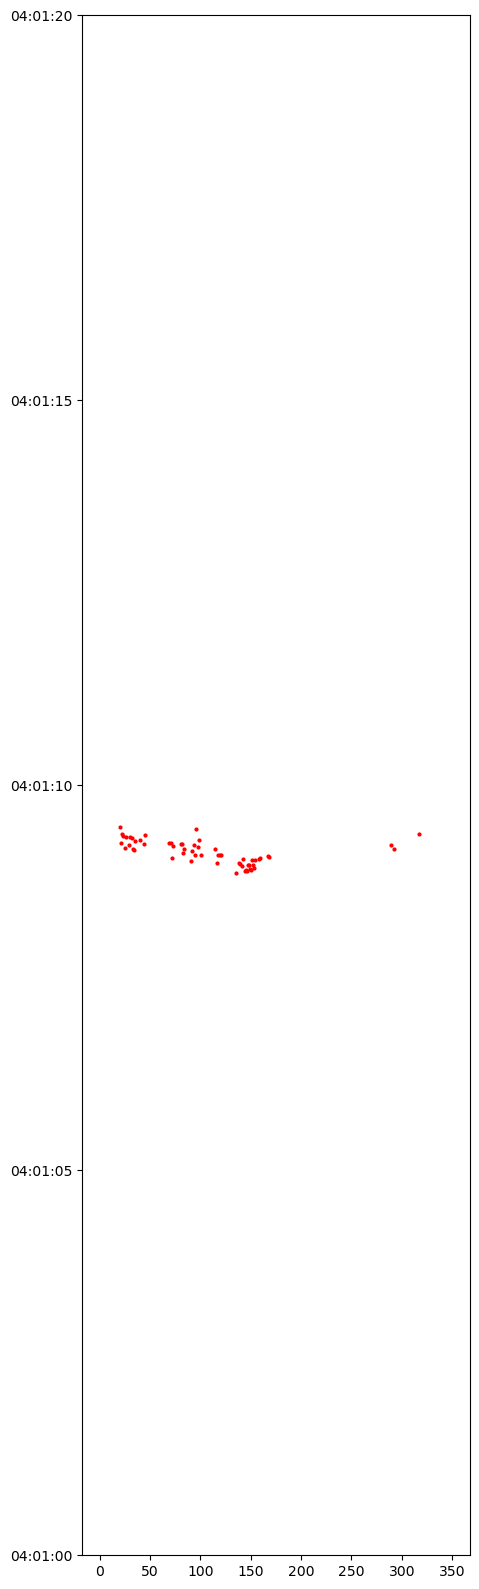

In [10]:
fig,ax = plt.subplots(figsize=(5,20))
for i, event in enumerate(grouped_detections):
    # print(f"Event {i+1}: {event}")
    cable_pos = np.asarray(event)[:,0]
    event_time = np.asarray(event)[:,1]
    ax.scatter(cable_pos, event_time, c = 'red', s = 4)

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

## 8.again.2 Plot one event

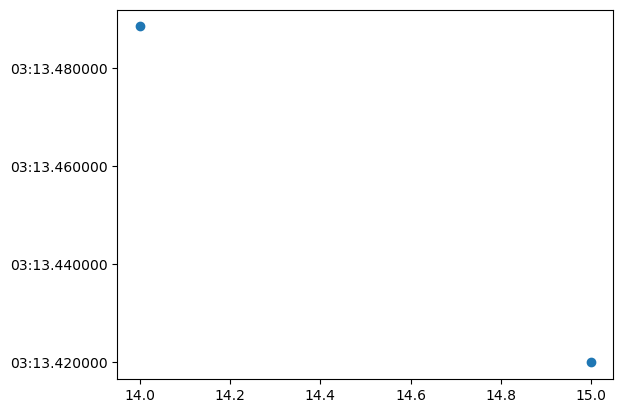

In [13]:
event_num = 311
event_arr = np.asarray(grouped_detections[event_num])
fig,ax = plt.subplots()
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

# 9. Further filter by only keeping events with more than "n" detections

In [12]:
def filter_small_events(events, min_detections):
    """
    Filters out events that have fewer than `min_detections` detections.

    Parameters:
        events (list): A list of events, where each event is a list of (distance, datetime) tuples.
        min_detections (int): Minimum number of detections required for an event to be kept.

    Returns:
        list: A filtered list of events with at least `min_detections` detections.
    """
    return [event for event in events if len(event) >= min_detections]

In [13]:
grouped_detections_culled = filter_small_events(grouped_detections, 20)

print(len(grouped_detections_culled))

289


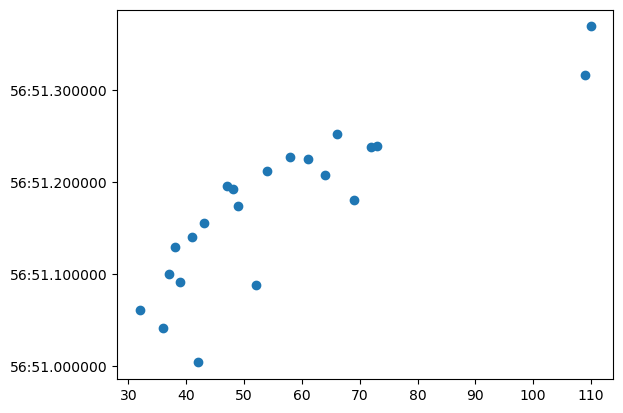

In [14]:
event_num = 262
event_arr = np.asarray(grouped_detections_culled[event_num])
fig,ax = plt.subplots()
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


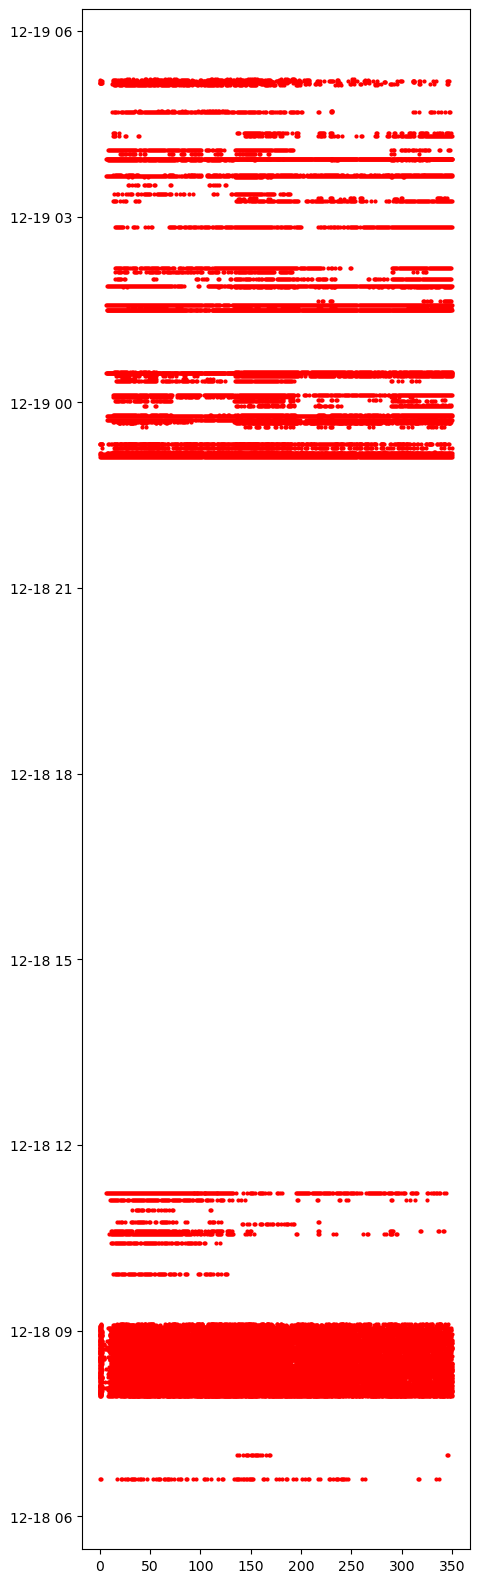

In [125]:
fig,ax = plt.subplots(figsize=(5,20))

for i in np.asarray(grouped_detections_culled):

    ax.scatter(np.asarray(i)[:,0], np.asarray(i)[:,1],  c = 'red', s = 4)

# ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

# 10. Plot the event and the data together to check accuracy

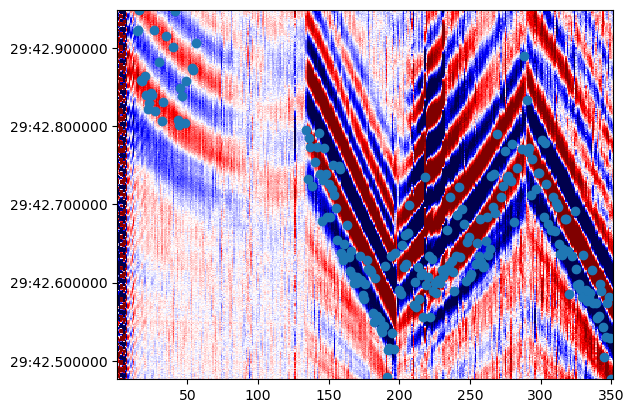

In [224]:

event_arr = np.asarray(grouped_detections_culled[event_num])

time_to_get = event_arr[:,1][0]
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time

f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

fig,ax = plt.subplots()
ax.pcolormesh(channels, times, filtered, vmin=-0.05, vmax=0.05, cmap='seismic')
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

ax.set_ylim([event_arr[:,1].min(), event_arr[:,1].max()])
plt.show()

# 12. Get times to a float number instead of datetime

In [15]:
grouped_detections_culled_arr = np.asarray(grouped_detections_culled)
picks_all = [[np.asarray(i)[:,0], [(dt - datetime.datetime(1970, 1, 1)).total_seconds() for dt in np.asarray(i)[:, 1]]] for i in grouped_detections_culled_arr]

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


# 13. Load the cable locations CSV

In [16]:
cable_loc = pd.read_csv('eastwind_coordinates_utm59s.csv', header=None)
cable_loc.rename(columns={0:'name', 1:'y', 2:'x', 3:'z'}, inplace=True)

In [17]:
cable_sections = [[0,132],[133,136], [137,192],[193,217],[218,285],[286,291],[292,350]]
cable_loc_names = [['D_0','D_12'],['D_12','D_17'], ['D_17','D_26'],['D_26','D_31'],['D_31','D_40'],['D_40','D_43'],['D_43','D_49']]


In [18]:
channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0]
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0]

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0]
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)

    for x,y in zip(x_vals, y_vals):
        channel_locations.append([x,y])

channel_locations = np.asarray(channel_locations)

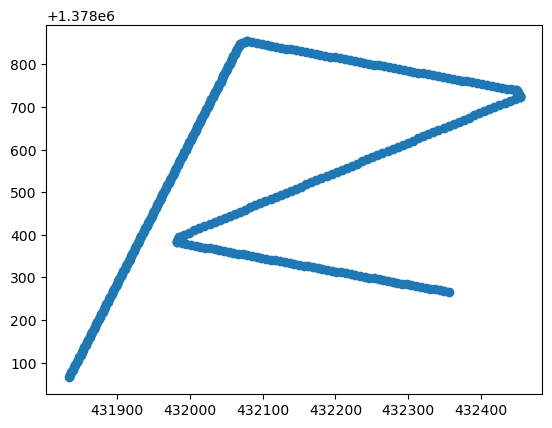

In [19]:
fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])

## Load the imagery

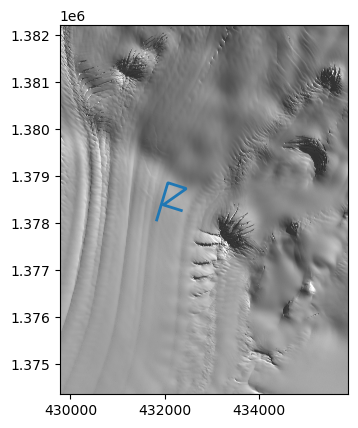

In [20]:
from rasterio.plot import show

# Specify the path to the GeoPackage file
gpkg_path = "imagery/eastwind_image_reproject_AOI_clip.tif"

fig,ax = plt.subplots()


# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed


ax.plot(channel_locations[:,0], channel_locations[:,1], lw=2)



# 14: Inverse Problem

In [97]:
### Priors ###
top_lim = 1390000
bottom_lim = 1370000

right_lim = 436000
left_lim = 428000

# min_offset = np.hstack(np.array(picks_all)[:,1]).min()
# max_offset = np.hstack(np.array(picks_all)[:,1]).max()

p_wavespeed_min = 100
p_wavespeed_max = 5000

s_wavespeed_min = 100
s_wavespeed_max = 5000

### Functions ###
def log_prior(theta, picks):
    s_x,s_y,t_offset,c_p,c_s = theta

    min_offset = np.array(picks[0][1]).min() - 5
    max_offset = np.array(picks[0][1]).min() + 0
    if left_lim < s_x < right_lim and bottom_lim < s_y < top_lim and min_offset < t_offset < max_offset and p_wavespeed_min < c_p < p_wavespeed_max and s_wavespeed_min < c_s < s_wavespeed_max:
        return 0.0
    return -np.inf

def log_likelihood(theta, picks):
    s_x,s_y,t_offset,c_p,c_s = theta
    chans_of_picks_p = np.array(picks[0][0], dtype=int)
    chans_of_picks_s = np.array(picks[1][0], dtype=int)

    distance_p = np.sqrt((channel_locations[chans_of_picks_p,0]-s_x)**2 + (channel_locations[chans_of_picks_p,1]-s_y)**2)   
    distance_s = np.sqrt((channel_locations[chans_of_picks_s,0]-s_x)**2 + (channel_locations[chans_of_picks_s,1]-s_y)**2)   

    model_p = distance_p/c_p + t_offset
    model_s = distance_s/c_s + t_offset

    best_line_coeffs = np.poly1d(np.polyfit(chans_of_picks_p, picks[0][1], 5))
    fit_line = np.polyval(best_line_coeffs, chans_of_picks_p)
    pick_residual = picks[0][1] - fit_line
    sigma = np.std(pick_residual)

    sigma2 = sigma**2
    #model =  t_offset + np.linalg.norm(channel_locations[chans_of_picks,:] - np.array([s_x, s_y]), axis=0) / c

    pwave_model_residual = np.sum((model_p - picks[0][1])**2)
    swave_model_residual = np.sum((model_s - picks[1][1])**2)
    ll = - 0.5 * np.sum((pwave_model_residual+swave_model_residual) / sigma2 + np.log(sigma2))

    return ll

def log_probability(theta, picks):
    lp = log_prior(theta, picks)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, picks)

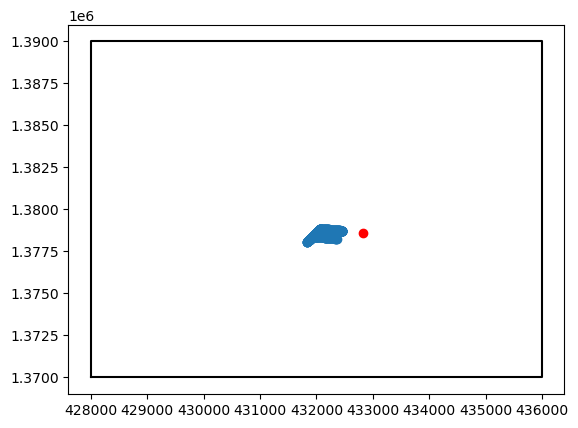

In [98]:
### Region of interest
# Make an initial guess on the source location
s_x_init = 432833.2600664
s_y_init = 1378618.37797727

fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter([s_x_init], [s_y_init], c='red')
ax.plot([left_lim,left_lim, right_lim, right_lim, left_lim],[bottom_lim,top_lim, top_lim, bottom_lim, bottom_lim], '-k')

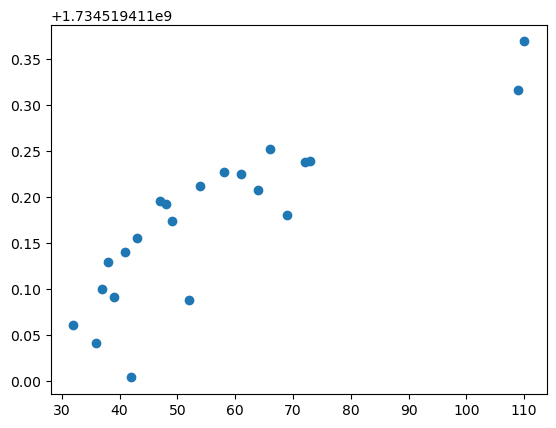

In [99]:
# Take one example to test, this is from the automated picks ###
event_num = 262
picks = picks_all[event_num]

fig, ax = plt.subplots()
ax.plot(picks[0], picks[1], 'o')

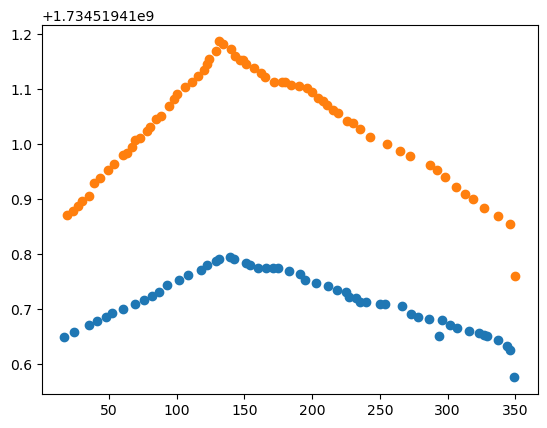

In [262]:
### Load this if using a manual pick ###

with open("basal_event_manual_pick_pwave.pkl", "rb") as p_manual:
    picks_p = pkl.load(p_manual)


with open("basal_event_manual_pick_swave.pkl", "rb") as s_manual:
    picks_s = pkl.load(s_manual)

picks_p = np.array(picks_p).T
picks_s = np.array(picks_s).T

fig, ax = plt.subplots()
ax.plot(picks_p[0], picks_p[1], 'o')
ax.plot(picks_s[0], picks_s[1], 'o')

p_and_s_picks = [[picks_p[0], picks_p[1]], [picks_s[0], picks_s[1]]]

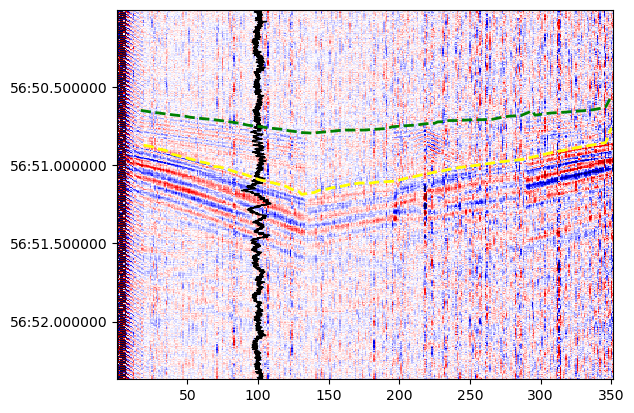

In [287]:
### Plot a few waveforms

event_arr = np.asarray(grouped_detections_culled[event_num])
time_to_get = event_arr[:,1][0]
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time

f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

fig, ax = plt.subplots()
# ax2 = ax.twinx()  # Create secondary y-axis

# Plot the colormap image
pcm = ax.pcolormesh(channels, times, filtered, vmin=-0.05, vmax=0.05, cmap='seismic')

# Set y-axis limits to the event time range
ax.set_ylim([event_arr[:,1].min() - datetime.timedelta(seconds=1), 
             event_arr[:,1].max() + datetime.timedelta(seconds=1)])

# Plot the waveform at channel 100 (scale and shift appropriately)
waveform = (filtered[:, 100] * 500) + 100  # Scale for visibility and shift to channel 100
ax.plot(waveform, times, color='black', linewidth=1)

datetime_picks_p = np.array([datetime.datetime.utcfromtimestamp(i) for i in p_and_s_picks[0][1]])
datetime_picks_s = np.array([datetime.datetime.utcfromtimestamp(i) for i in p_and_s_picks[1][1]])

ax.plot(p_and_s_picks[0][0], datetime_picks_p, lw=2, ls = '--', c='green', label = 'Manual P Picks')
ax.plot(p_and_s_picks[1][0], datetime_picks_s, lw=2, ls = '--', c='yellow', label = 'Manual S Picks')

ax.invert_yaxis()  # Invert y-axis for correct time ordering

plt.show()

In [102]:
### Make an inital guess on the time offset and velocity ###

offset_init = np.array(p_and_s_picks[0][1]).min() -0
c_p_init = 2000
c_s_init = 1000

### initial guesses ###
num_resets = 32

init_guesses = np.array([s_x_init, s_y_init, offset_init, c_p_init, c_s_init])

initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e-6, 1e2, 1e2])

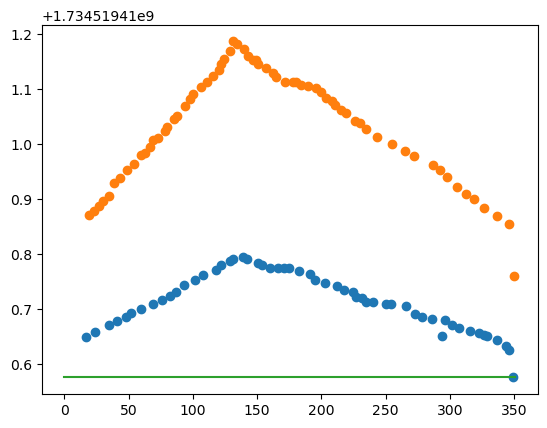

In [103]:
fig, ax = plt.subplots()
ax.plot(p_and_s_picks[0][0], p_and_s_picks[0][1], 'o')
ax.plot(p_and_s_picks[1][0], p_and_s_picks[1][1], 'o')
ax.plot([0,351],[offset_init, offset_init])

In [104]:
### Run the MCMC  on just one for a test ###

nwalkers, ndim = initial.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=[p_and_s_picks]
)
sampler.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:34<00:00, 143.01it/s]


In [105]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 5)


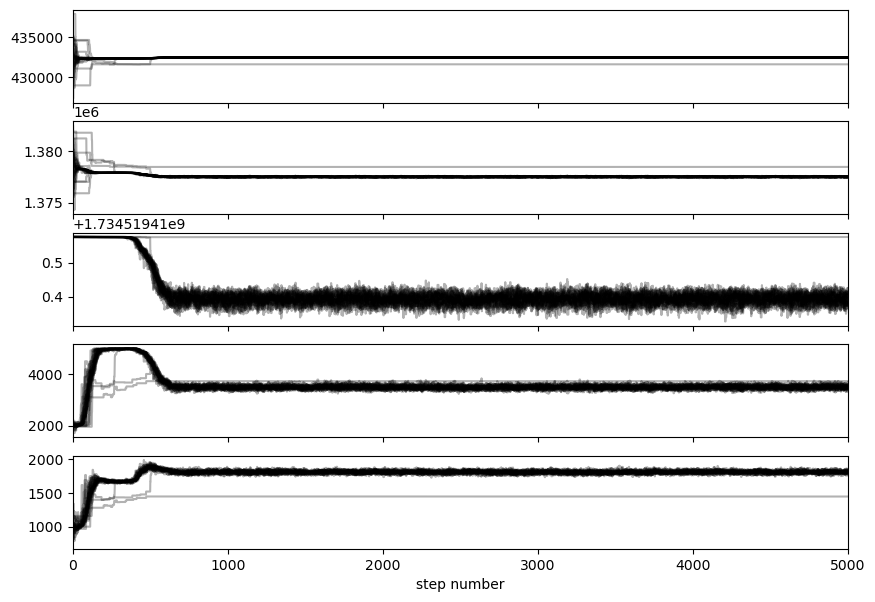

In [106]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))

    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

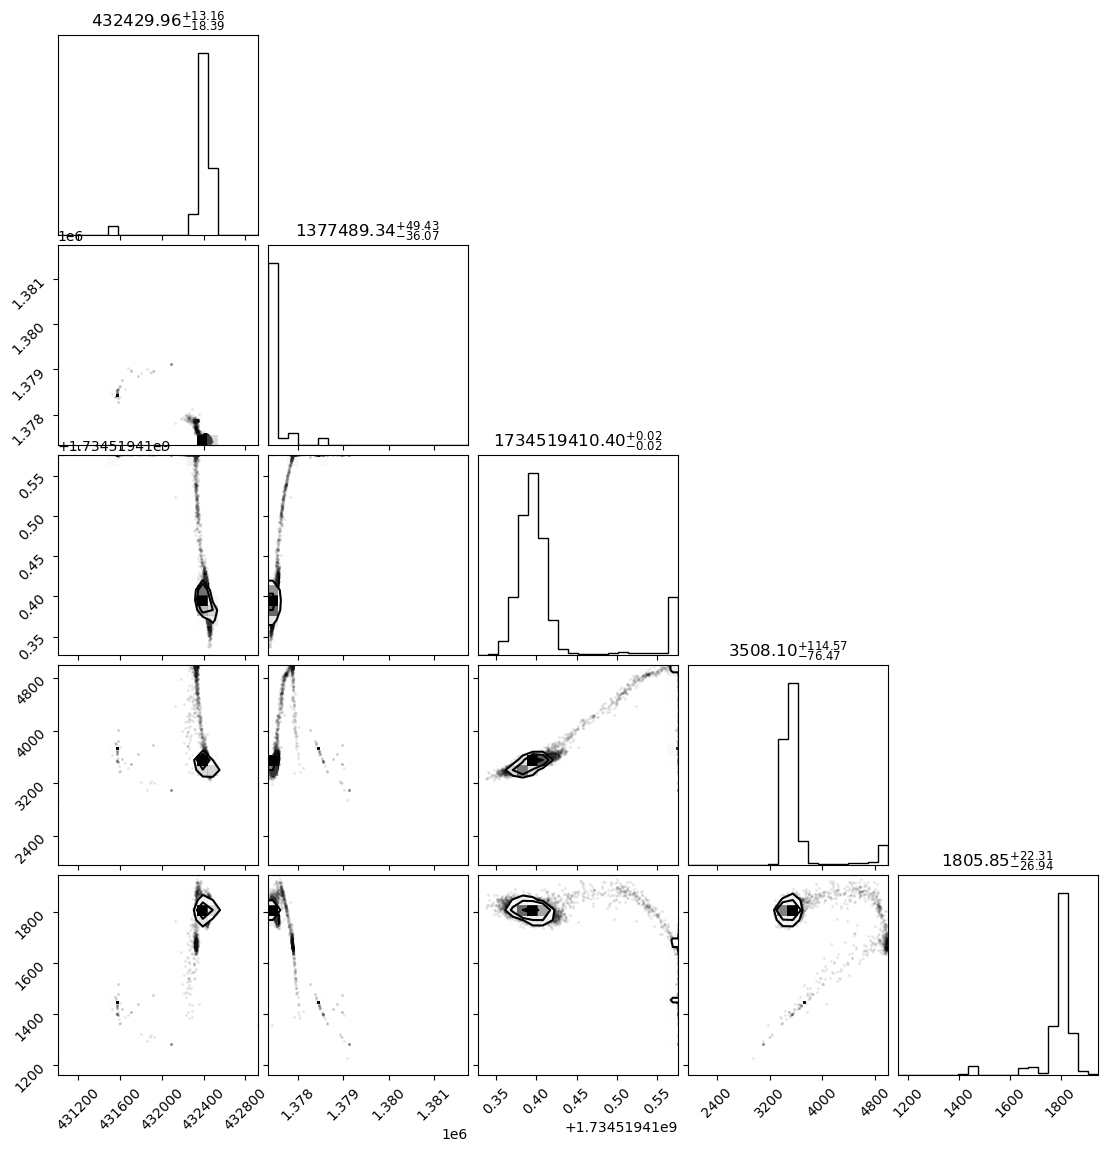

In [107]:
import corner

fig = corner.corner(
    flat_samples, show_titles=True
);

In [109]:
median_x = np.median(flat_samples[:,0])
median_y = np.median(flat_samples[:,1])
median_offset = np.median(flat_samples[:,2])
median_c_p = np.median(flat_samples[:,3])
median_c_s = np.median(flat_samples[:,4])

xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
z_locs = gaussian_kde(xy_locs)(xy_locs)

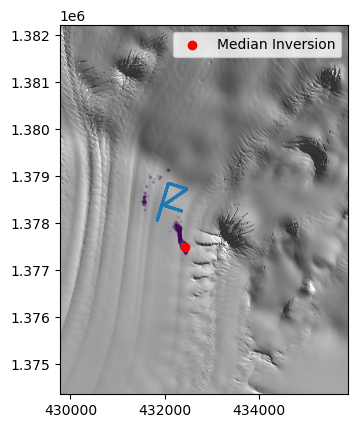

In [110]:
# Median inversion on the source location

fig,ax = plt.subplots()

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 


ax.scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 0.1)
ax.scatter(channel_locations[:,0], channel_locations[:,1], s = 1)
ax.scatter([median_x], [median_y], c='red', label='Median Inversion')
# ax.set_ylim([1.377e6, 1.38e6])
# ax.set_xlim([4.3e5, 4.34e5])
ax.legend()

### Plot the inversion and the triggers together

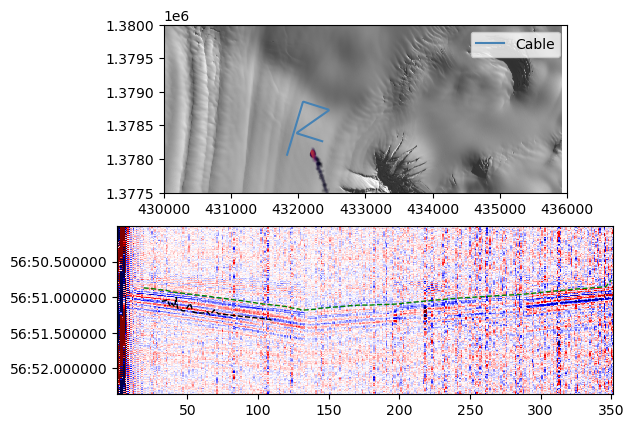

In [80]:
# Median inversion on the source location

fig,axes = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 3], 'width_ratios': [5]})

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=axes[0]) 


axes[0].scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 0.05, cmap = 'inferno')
axes[0].plot(channel_locations[:,0], channel_locations[:,1], label = 'Cable', c = 'steelblue')
#axes[0].scatter([median_x], [median_y], c='red', label='Median Inversion')

axes[0]. set_xlim([430000, 436000])
axes[0]. set_ylim([1.3775e6, 1.38e6])
axes[0].legend()

event_arr = np.asarray(grouped_detections_culled[event_num])

time_to_get = event_arr[:,1][0]
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time

f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)


axes[1].pcolormesh(channels, times, filtered, vmin=-0.05, vmax=0.05, cmap='seismic')

axes[1].plot(event_arr[:,0], event_arr[:,1], lw=1, ls = '--', c='black', label = 'Automated Picks')

datetime_picks = np.array([datetime.datetime.utcfromtimestamp(i) for i in picks[1]])
axes[1].plot(picks[0], datetime_picks, lw=1, ls = '--', c='green', label = 'Manual Picks')

axes[1].set_ylim([event_arr[:,1].min() - datetime.timedelta(seconds=1), event_arr[:,1].max()+ datetime.timedelta(seconds=1)])

axes[1].invert_yaxis()
# axes[1].legend()
plt.show()


### Run EMCEE for all picks

In [139]:
### Make an inital guess on the time offset and velocity ###


c_init = 1000
# Make an initial guess on the source location, basically the middle
s_x_init = 432033.2600664
s_y_init = 1378618.37797727

### initial guesses ###
num_resets = 50

init_guesses = np.array([s_x_init, s_y_init, offset_init, c_init])

initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) *  np.array([2e3, 2e3, 1e-6, 1e2])

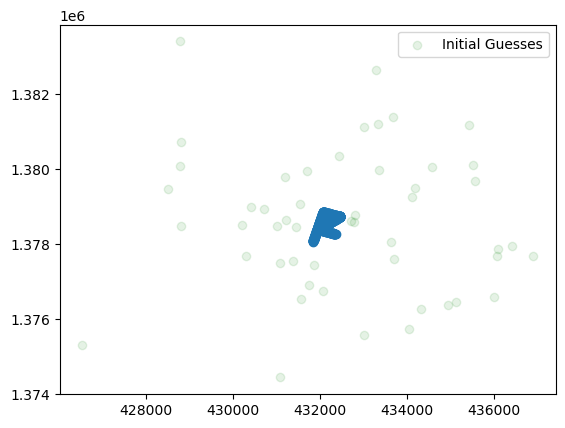

In [140]:
fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter(initial[:,0], initial[:,1], c='green', alpha=0.1, label='Initial Guesses')
ax.legend()

  4%|▍         | 11/289 [00:43<11:47,  2.54s/it] Traceback (most recent call last):
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_136057/998342498.py", line 48, in log_probability
    return lp + log_likelihood(theta, picks)
  File "/tmp/ipykernel_136057/998342498.py", line 33, in log_likelihood
    best_line_coeffs = np.poly1d(np.polyfit(chans_of_picks, picks[1], 5))
  File "<__array_function__ internals>", line 6, in polyfit
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/numpy/lib/polynomial.py", line 622, in polyfit
    y = NX.asarray(y) + 0.0
KeyboardInterrupt
  4%|▍         | 11/289 [00:48<20:30,  4.43s/it]

emcee: Exception while calling your likelihood function:
  params: [4.33300305e+05 1.37644631e+06 1.73450886e+09 1.12908591e+03]
  args: [[array([0.0, 1.0, 21.0, 24.0, 27.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0,
       37.0, 38.0, 40.0, 40.0, 45.0, 45.0, 46.0, 47.0, 49.0, 51.0, 52.0,
       53.0, 56.0, 57.0, 58.0, 59.0, 60.0, 64.0, 70.0, 72.0, 73.0, 74.0,
       75.0, 76.0, 84.0, 86.0, 87.0, 88.0, 90.0, 93.0, 94.0, 95.0, 96.0,
       97.0, 103.0, 105.0, 107.0, 110.0, 113.0, 114.0, 118.0, 118.0,
       120.0, 122.0, 123.0, 124.0, 125.0, 125.0, 126.0, 128.0, 129.0,
       129.0, 130.0, 131.0, 132.0, 134.0, 137.0, 138.0, 140.0, 144.0,
       145.0, 146.0, 146.0, 147.0, 147.0, 148.0, 149.0, 152.0, 155.0,
       156.0, 157.0, 171.0, 173.0, 174.0, 175.0, 177.0, 184.0, 185.0,
       187.0, 195.0, 197.0, 202.0, 203.0, 204.0, 209.0, 212.0, 216.0,
       218.0, 225.0, 227.0, 231.0, 231.0, 237.0, 239.0, 242.0, 257.0,
       259.0, 261.0, 268.0, 269.0, 272.0, 273.0, 277.0, 278.0, 281.0,
       282.0

KeyboardInterrupt: 

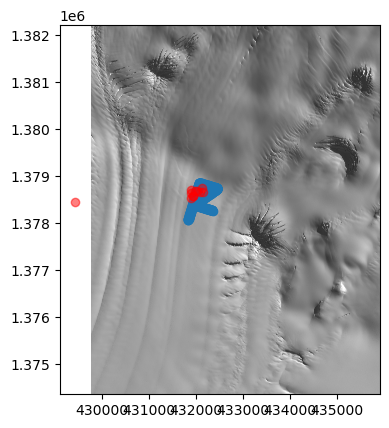

In [141]:
### Run the inversion for all picks ###
fig,ax = plt.subplots()

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed
ax.scatter(channel_locations[:,0], channel_locations[:,1])


flat_samples_all = {}

n = 0 
for picks in tqdm(picks_all):
    ## make the initial offset pick the time of the first arrival ##
    offset_init = picks[1][0] - 1e-7

    ## make the initial guess array ##
    init_guesses = np.array([s_x_init, s_y_init, offset_init, c_init])

    initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) *  np.array([5e2, 5e2, 1e-6, 1e2])
    nwalkers, ndim = initial.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=[picks]
    )
    sampler.run_mcmc(initial, 2000);

    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    flat_samples_all['Event ' + str(n)] = flat_samples
    median_x = np.median(flat_samples[:,0])
    median_y = np.median(flat_samples[:,1])
    median_offset = np.median(flat_samples[:,2])
    median_c = np.median(flat_samples[:,3])
    ax.scatter([median_x], [median_y], c='red', alpha=0.5)

    n+=1

# 16. Inverion with a z coordinate

In [252]:
### Priors ###
top_lim = 1390000
bottom_lim = 1370000

right_lim = 436000
left_lim = 428000

depth_lim = -1000
height_lim = 100

p_wavespeed_min = 100
p_wavespeed_max = 5000

s_wavespeed_min = 100
s_wavespeed_max = 5000

### Functions ###
def log_prior(theta, picks):
    s_x,s_y,s_z,t_offset,c_p,c_s = theta

    min_offset = np.array(picks[0][1]).min() - 5
    max_offset = np.array(picks[0][1]).min() + 0
    if (left_lim < s_x < right_lim 
    and bottom_lim < s_y < top_lim 
    and depth_lim < s_z < height_lim 
    and min_offset < t_offset < max_offset 
    and p_wavespeed_min < c_p < p_wavespeed_max 
    and s_wavespeed_min < c_s < s_wavespeed_max):
        return 0.0
    return -np.inf

def log_likelihood(theta, picks):
    s_x,s_y,s_z,t_offset,c_p,c_s = theta
    chans_of_picks_p = np.array(picks[0][0], dtype=int)
    chans_of_picks_s = np.array(picks[1][0], dtype=int)

    distance_p = np.sqrt((channel_locations[chans_of_picks_p,0]-s_x)**2 + (channel_locations[chans_of_picks_p,1]-s_y)**2 + (channel_locations[chans_of_picks_p,2]-s_z)**2)   
    distance_s = np.sqrt((channel_locations[chans_of_picks_s,0]-s_x)**2 + (channel_locations[chans_of_picks_s,1]-s_y)**2 + (channel_locations[chans_of_picks_s,2]-s_z)**2)   

    model_p = distance_p/c_p + t_offset
    model_s = distance_s/c_s + t_offset

    best_line_coeffs = np.poly1d(np.polyfit(chans_of_picks_p, picks[0][1], 5))
    fit_line = np.polyval(best_line_coeffs, chans_of_picks_p)
    pick_residual = picks[0][1] - fit_line
    sigma = np.std(pick_residual)

    sigma2 = sigma**2
    #model =  t_offset + np.linalg.norm(channel_locations[chans_of_picks,:] - np.array([s_x, s_y]), axis=0) / c

    pwave_model_residual = np.sum((model_p - picks[0][1])**2)
    swave_model_residual = np.sum((model_s - picks[1][1])**2)
    ll = -0.5 * np.sum((pwave_model_residual + swave_model_residual) / (4 * sigma2) + np.log(2 * np.pi * sigma2))

    return ll

def log_probability(theta, picks):
    lp = log_prior(theta, picks)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    return lp + log_likelihood(theta, picks), lp + log_likelihood(theta, picks)

dtype = [("log_prob", float)]

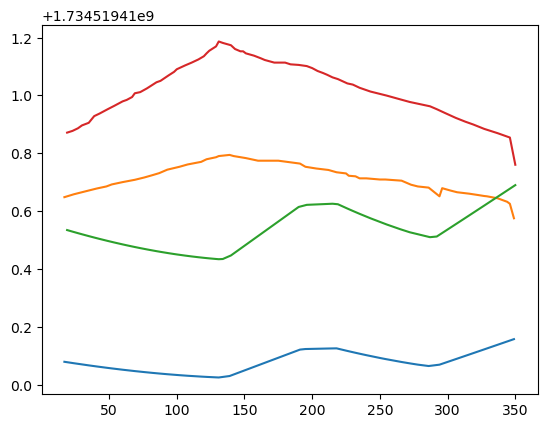

In [221]:
fig, ax = plt.subplots()
ax.plot(chans_of_picks_p, model_p)
ax.plot(chans_of_picks_p, picks[0][1] )

ax.plot(chans_of_picks_s, model_s)
ax.plot(chans_of_picks_s, picks[1][1] )

In [244]:
channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0]
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0]

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0]
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0]

    z_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'z'].iloc[0]
    z_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'z'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)
    z_vals = np.linspace(z_start, z_end, chan_num[1]-chan_num[0]+1)

    for x,y,z in zip(x_vals, y_vals, z_vals):
        channel_locations.append([x,y,z])

channel_locations = np.asarray(channel_locations)

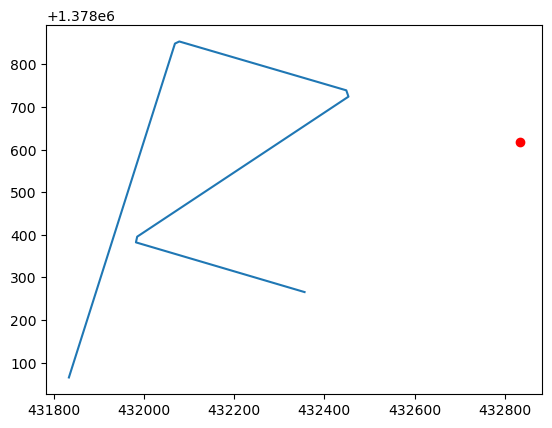

In [245]:
# Make an initial guess on the source location
s_x_init = 432833.2600664
s_y_init = 1378618.37797727
s_z_init = -10


fig,ax = plt.subplots()
ax.plot(channel_locations[:,0], channel_locations[:,1])
ax.scatter([s_x_init], [s_y_init], c='red')

### Do this if taking an automatic pick

Text(0.5, 1.0, '262')

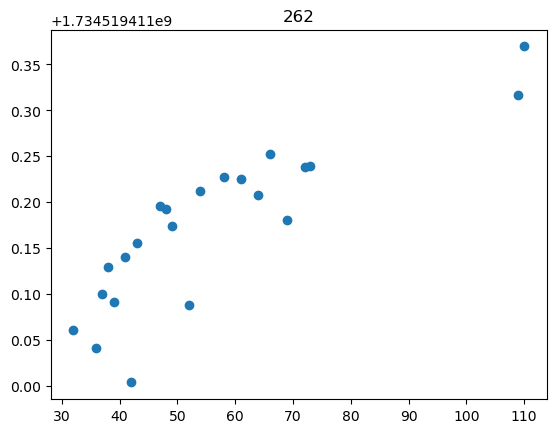

In [246]:
# Take one example to test ###
event_num = 262
picks = picks_all[event_num]

fig, ax = plt.subplots()
ax.plot(picks[0], picks[1], 'o')
ax.set_title(str(event_num))

### Do this if using a manual pick

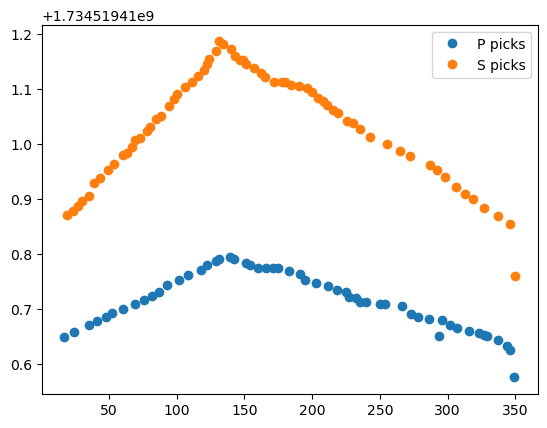

In [247]:
### Load this if using a manual pick ###

with open("basal_event_manual_pick_pwave.pkl", "rb") as p_manual:
    picks_p = pkl.load(p_manual)


with open("basal_event_manual_pick_swave.pkl", "rb") as s_manual:
    picks_s = pkl.load(s_manual)

picks_p = np.array(picks_p).T
picks_s = np.array(picks_s).T

fig, ax = plt.subplots()
# ax.plot(picks_p[0], picks_p[1], 'o')
# ax.plot(picks_s[0], picks_s[1], 'o')

p_and_s_picks = [[picks_p[0], picks_p[1]], [picks_s[0], picks_s[1]]]

ax.plot(p_and_s_picks[0][0], p_and_s_picks[0][1], 'o', label = 'P picks')
ax.plot(p_and_s_picks[1][0], p_and_s_picks[1][1], 'o', label = 'S picks')
ax.legend()

In [253]:
### Make an inital guess on the time offset and velocity ###

offset_init = np.array(p_and_s_picks[0][1]).min() -1
c_p_init = 4000
c_s_init = 2000

### initial guesses ###
num_resets = 32

init_guesses = np.array([s_x_init, s_y_init, s_z_init, offset_init, c_p_init, c_s_init])

initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e1, 1e-6, 1e2, 1e2])


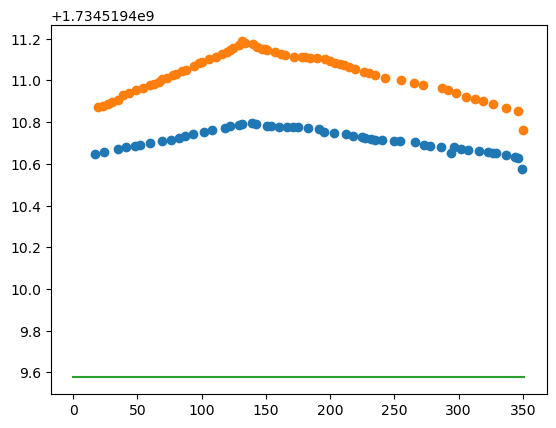

In [254]:
fig, ax = plt.subplots()

ax.plot(p_and_s_picks[0][0], p_and_s_picks[0][1], 'o', label = 'P picks')
ax.plot(p_and_s_picks[1][0], p_and_s_picks[1][1], 'o', label = 'S picks')

ax.plot([0,351],[offset_init, offset_init])


In [255]:
### Run the MCMC  on just one for a test ###

nwalkers, ndim = initial.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=[p_and_s_picks], blobs_dtype = dtype
)
sampler.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [01:00<00:00, 82.04it/s]


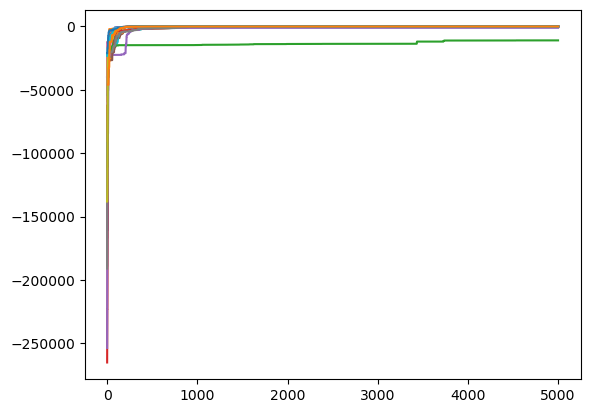

In [256]:
blobs = sampler.get_blobs()
fig, ax = plt.subplots()
ax.plot(blobs)

In [257]:
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
print(flat_samples.shape)

(4256, 6)


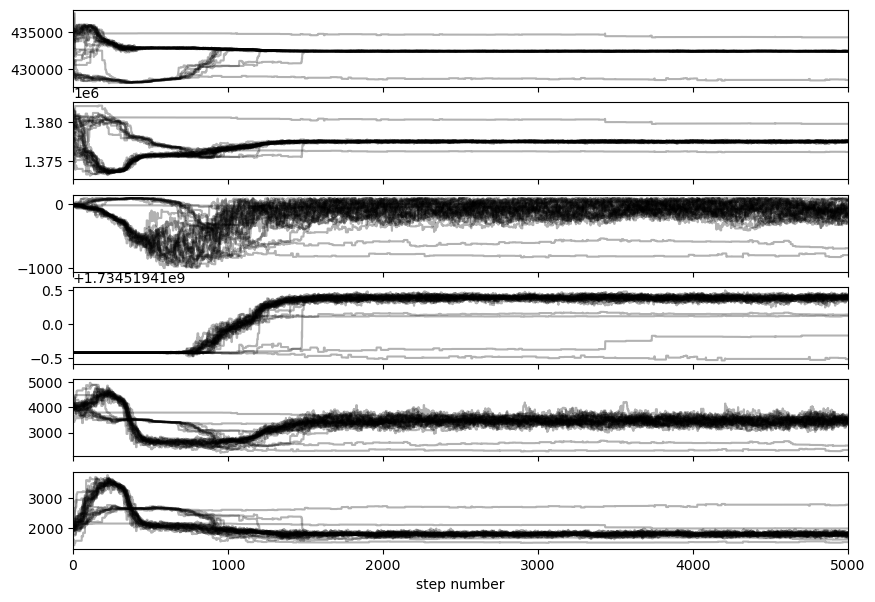

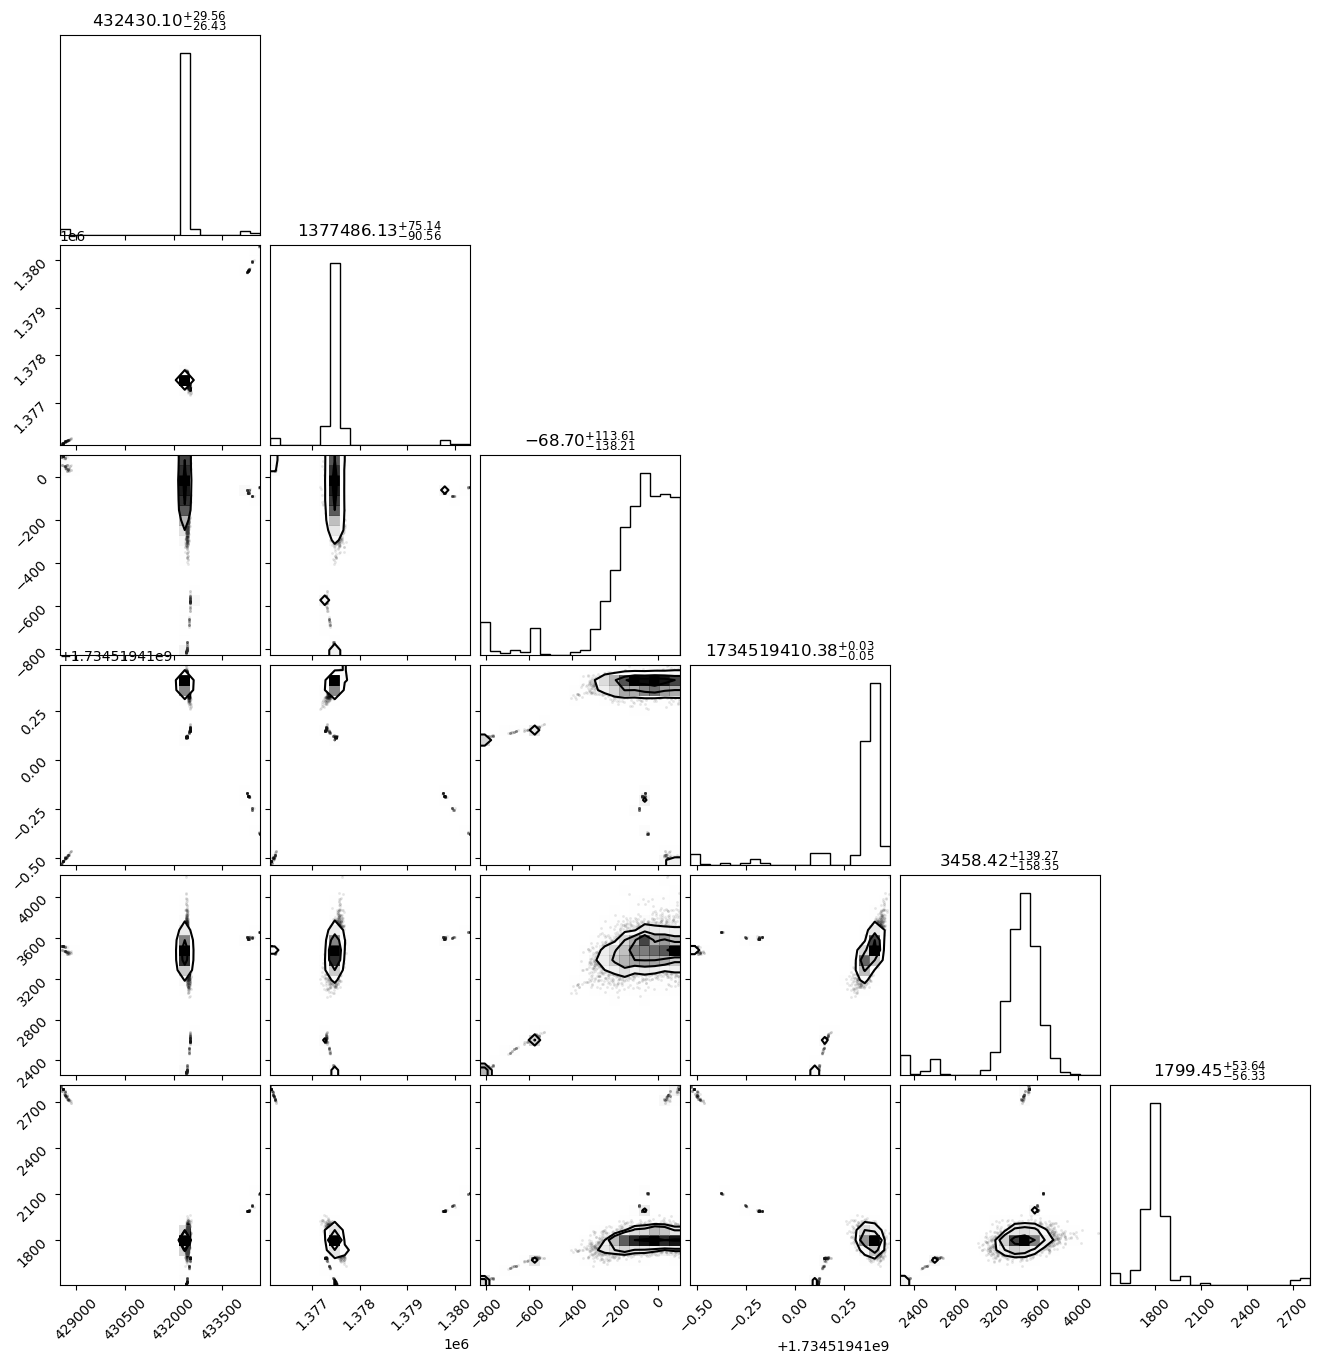

In [258]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))

    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

import corner

fig = corner.corner(
    flat_samples, show_titles=True
);

In [259]:
# median_x = np.median(flat_samples[:,0])
# median_y = np.median(flat_samples[:,1])
# median_z = np.median(flat_samples[:,2])
# median_offset = np.median(flat_samples[:,3])
# median_c = np.median(flat_samples[:,4])

# xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
# z_locs = gaussian_kde(xy_locs)(xy_locs)

median_x = np.median(flat_samples[:,0])
median_y = np.median(flat_samples[:,1])
median_z = np.median(flat_samples[:,2])
median_offset = np.median(flat_samples[:,3])
median_c_p = np.median(flat_samples[:,4])
median_c_s = np.median(flat_samples[:,5])

xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
z_locs = gaussian_kde(xy_locs)(xy_locs)

cable_mean_x = np.mean(channel_locations[:,0])
cable_mean_y = np.mean(channel_locations[:,1])

horizontal_distance = np.sqrt((flat_samples[:,0]-cable_mean_x)**2 + (flat_samples[:,1]-cable_mean_y)**2)

xyz_locs = np.vstack([horizontal_distance, flat_samples[:,2]])
depth_locs = gaussian_kde(xyz_locs)(xyz_locs)

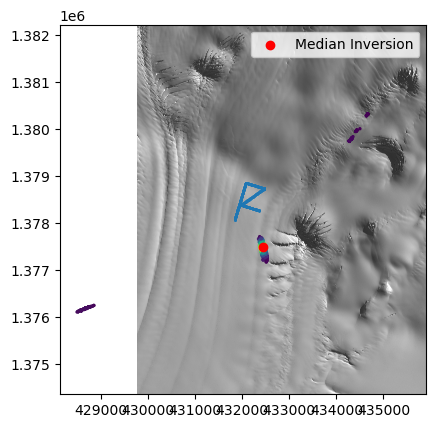

In [260]:
# Median inversion on the source location

fig,ax = plt.subplots()

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 


ax.scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 1)
ax.scatter(channel_locations[:,0], channel_locations[:,1], s = 1)
ax.scatter([median_x], [median_y], c='red', label='Median Inversion')
# ax.set_ylim([1.377e6, 1.38e6])
# ax.set_xlim([4.3e5, 4.34e5])
ax.legend()

Text(0, 0.5, 'Depth (m)')

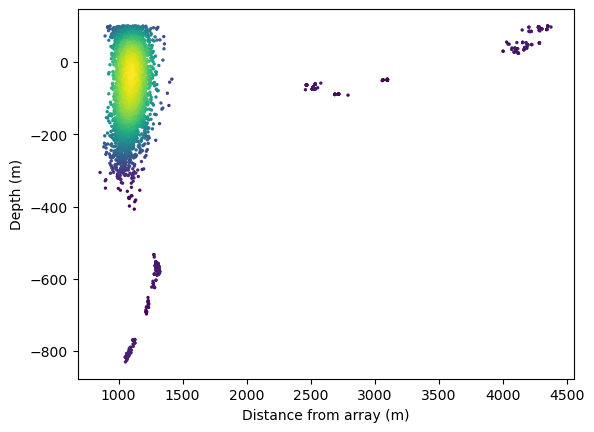

In [261]:
fig, ax = plt.subplots()


median_distance = np.sqrt(median_x**2 + median_y**2)


ax.scatter(horizontal_distance, flat_samples[:,2], c=depth_locs, s=2, alpha = 1)
# ax.scatter(channel_locations[:,0], channel_locations[:,1], s = 1)
#ax.scatter(median_distance, [median_z], c='red', label='Median Inversion')
# ax.set_ylim([1.377e6, 1.38e6])
ax.set_xlabel('Distance from array (m)')
ax.set_ylabel('Depth (m)')



# Synthetic example

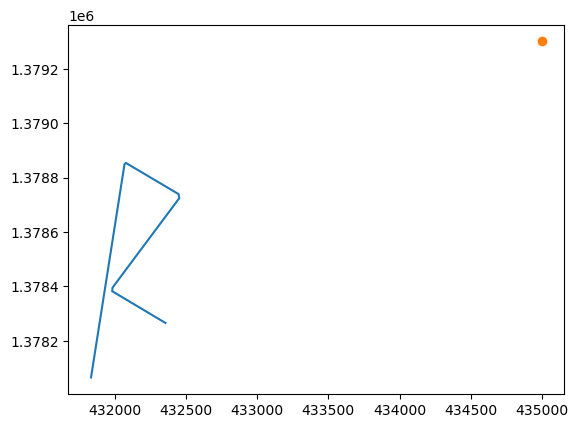

In [224]:
# Synthetic source info
synth_x = 435000
synth_y = 1.3793e6


event_time_synth = datetime.datetime(2025,1,19,10,55,9,22222)
c_synth = 1500
event_time_synth_in_secs = (event_time_synth - datetime.datetime(1970, 1, 1)).total_seconds()

# Plot the source location
fig, ax = plt.subplots()

ax.plot(channel_locations[:,0], channel_locations[:,1])
ax.plot(synth_x, synth_y, 'o')


In [225]:

secs_to_add = np.sqrt((channel_locations[:,0] - synth_x)**2 + (channel_locations[:,1] - synth_y)**2) / c_synth 
picks_synth = [event_time_synth + datetime.timedelta(seconds=i) for i in secs_to_add]
picks_synth_secs = [(dt - datetime.datetime(1970, 1, 1)).total_seconds() for dt in picks_synth]

picks_synth_secs_with_noise = picks_synth_secs + (np.random.rand(len(picks_synth_secs)) - 0.5)*1e-2
picks_synth_secs_with_noise = picks_synth_secs 

chans_synth = np.arange(0.,len(picks_synth_secs_with_noise), 1,dtype=object)
chans_and_picks = [chans_synth, picks_synth_secs_with_noise]

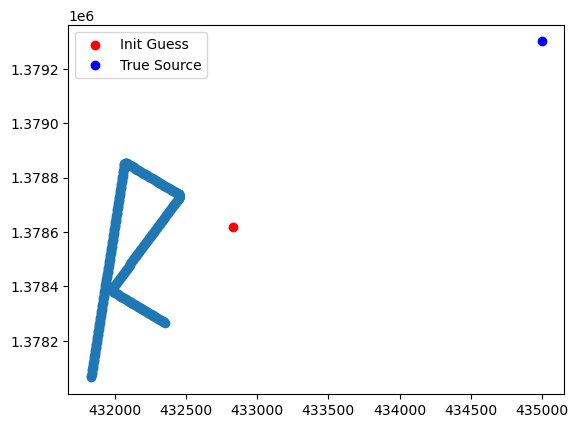

In [226]:
# Make an initial guess on the source location
synth_x_init = 432833.2600664
synth_y_init = 1378618.37797727


fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter([synth_x_init], [synth_y_init], c='red', label = 'Init Guess')
ax.scatter([synth_x], [synth_y], c='blue', label = 'True Source')

ax.legend()

In [227]:
### Make an inital guess on the time offset and velocity ###

synth_offset_init = np.array(chans_and_picks[1]).min() -0
synth_c_init = 1000

### initial guesses ###
synth_num_resets = 50

synth_init_guesses = np.array([synth_x_init, synth_y_init, synth_offset_init, synth_c_init])

synth_initial = synth_init_guesses + np.random.randn(synth_num_resets, len(synth_init_guesses)) * np.array([2e3, 2e3, 1e-6, 1e2])

In [228]:
### Run the MCMC  on just one for a test ###

nwalkers, ndim = synth_initial.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=[chans_and_picks]
)
sampler.run_mcmc(synth_initial, 5000, progress=True);

100%|██████████| 5000/5000 [00:29<00:00, 169.17it/s]


(16300, 4)


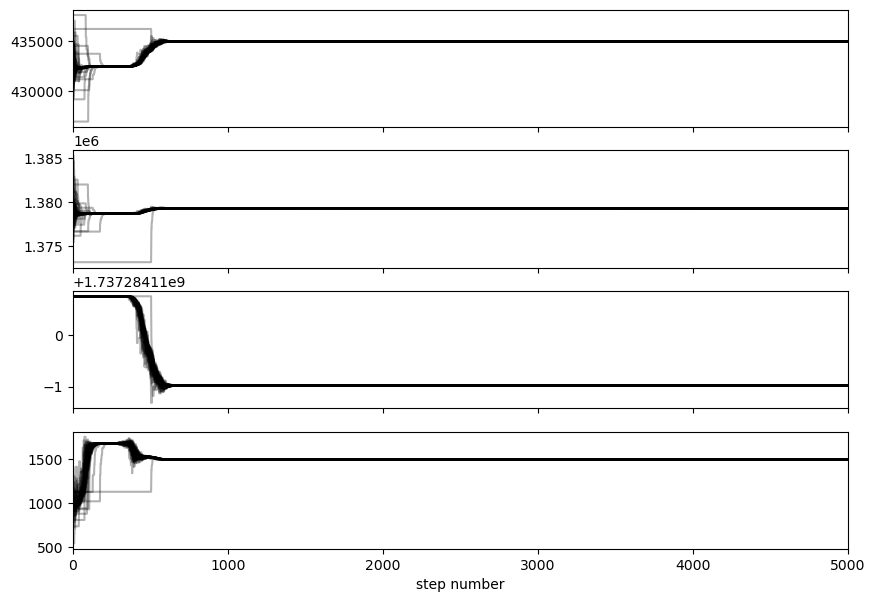

In [229]:
synth_flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(synth_flat_samples.shape)

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))

    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

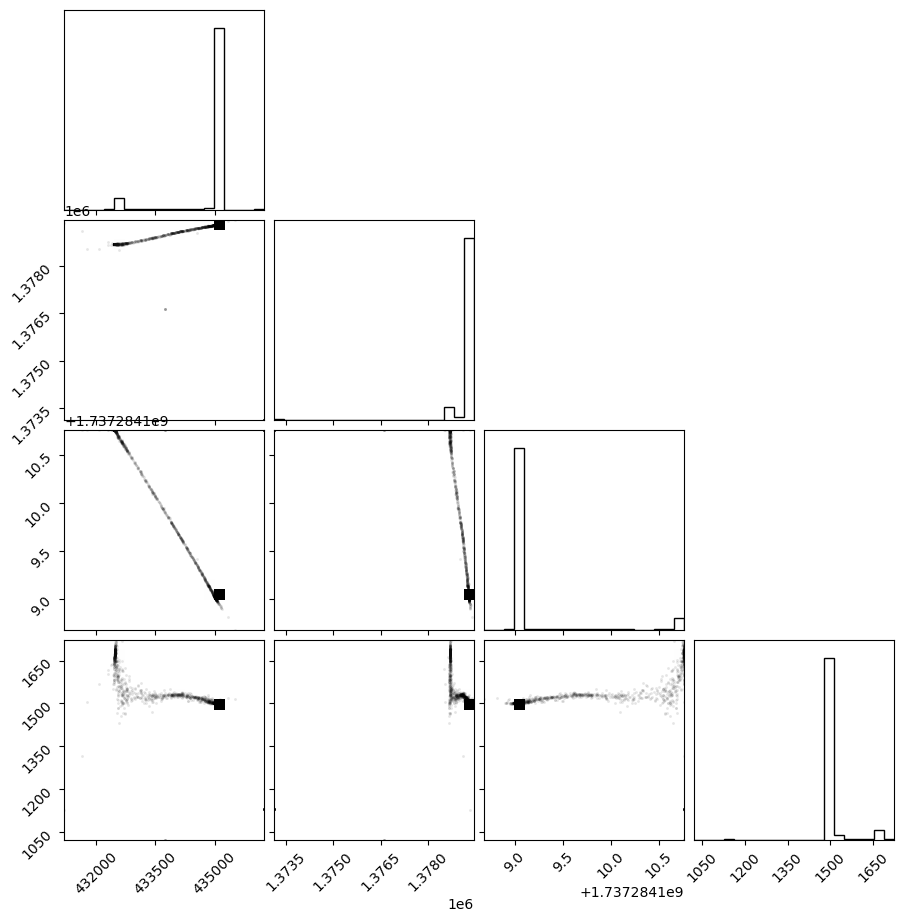

In [230]:
import corner

fig = corner.corner(
    synth_flat_samples
);

In [231]:
synth_xy_locs = np.vstack([synth_flat_samples[:,0],synth_flat_samples[:,1]])
synth_z_locs = gaussian_kde(synth_xy_locs)(synth_xy_locs)

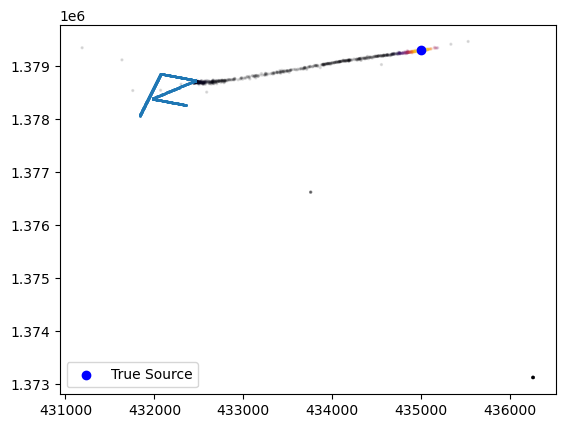

In [232]:
fig, ax = plt.subplots()

ax.scatter(synth_flat_samples[:,0], synth_flat_samples[:,1], c=synth_z_locs, s=2, alpha = 0.1, cmap='inferno')
ax.scatter(channel_locations[:,0], channel_locations[:,1], s = 1)
ax.scatter([synth_x], [synth_y], c='blue', label = 'True Source')
ax.legend()